---
title: "No Fear At That Age"
author: "Diggy"
date: 2025-09-29
layout: post
categories: [football, analysis]
tags: [python, plotly]
format:
  gfm:
    df-print: default
    toc: false
fig-format: png
fig-dpi: 144
execute:
  echo: false      # hide code by default
  include: false    # include outputs
  warning: false
  message: false
  cache: false
freeze: false
---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import chardet
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import probplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
import os
from pathlib import Path
from IPython.display import display, Markdown

sns.set_theme(context='notebook', style='ticks', palette='colorblind')

In [2]:
#| echo: false      # hide code by default
#| include: false

with open("NoFearAtThatAge.csv", "rb") as f:
    raw = f.read(50000)   # read first 50 KB
    print(chardet.detect(raw))

df = pd.read_csv("NoFearAtThatAge.csv", encoding="MacRoman")
df.head(10)

{'encoding': 'MacRoman', 'confidence': 0.7231101779644071, 'language': ''}


,Player,Season,Age,Nation,Team,Comp,Pos,PKatt,PK,PKm,Conversion%,conversion_rate
0,Cristiano Ronaldo,2011-2012,26.0,pt POR,Real Madrid,La Liga,"FW,MF",13.0,12.0,1.0,92.31,0.923077
1,Salva Ballesta,1999-2000,24.0,es ESP,Racing Sant,La Liga,FW,12.0,11.0,1.0,91.67,0.916667
2,Andrew Johnson,2004-2005,23.0,eng ENG,Crystal Palace,EPL,FW,12.0,10.0,2.0,83.33,0.833333
3,Alan Shearer,1994-1995,23.0,eng ENG,Blackburn,EPL,FW,12.0,10.0,2.0,83.33,0.833333
4,Steven Gerrard,2013-2014,33.0,eng ENG,Liverpool,EPL,MF,11.0,10.0,1.0,90.91,0.909091
5,Luka Milivojeviƒá,2018-2019,27.0,rs SRB,Crystal Palace,EPL,MF,11.0,10.0,1.0,90.91,0.909091
6,Frank Lampard,2009-2010,31.0,eng ENG,Chelsea,EPL,MF,11.0,10.0,1.0,90.91,0.909091
7,Cristiano Ronaldo,2014-2015,29.0,pt POR,Real Madrid,La Liga,"FW,MF",12.0,10.0,2.0,83.33,0.833333
8,Lionel Messi,2011-2012,24.0,ar ARG,Barcelona,La Liga,"FW,MF",11.0,10.0,1.0,90.91,0.909091
9,Gerard Moreno,2020-2021,28.0,es ESP,Villarreal,La Liga,FW,10.0,10.0,0.0,100.00,1.000000


In [3]:
#| echo: false
#| include: false
league_season_dim = pd.DataFrame([
    # EPL
    ("EPL","1992-1993",22,462),
    ("EPL","1993-1994",22,462),
    ("EPL","1994-1995",22,462),
    # 20-team standard
    *[( "EPL", s, 20, 380) for s in [f"{y}-{y+1}" for y in range(1995, 2025)]],
    # Two group-stage era
    ("CL","1999-2000",32,157),
    ("CL","2000-2001",32,157),
    ("CL","2001-2002",32,157),
    ("CL","2002-2003",32,157),
    # Standard 32-team format
    ("CL","2003-2004",32,125),
    ("CL","2004-2005",32,125),
    ("CL","2005-2006",32,125),
    ("CL","2006-2007",32,125),
    ("CL","2007-2008",32,125),
    ("CL","2008-2009",32,125),
    ("CL","2009-2010",32,125),
    ("CL","2010-2011",32,125),
    ("CL","2011-2012",32,125),
    ("CL","2012-2013",32,125),
    ("CL","2013-2014",32,125),
    ("CL","2014-2015",32,125),
    ("CL","2015-2016",32,125),
    ("CL","2016-2017",32,125),
    ("CL","2017-2018",32,125),
    ("CL","2018-2019",32,125),
    ("CL","2019-2020",32,119),  # COVID Final-8
    ("CL","2020-2021",32,125),
    ("CL","2021-2022",32,125),
    ("CL","2022-2023",32,125),
    ("CL","2023-2024",32,125),
    # New Swiss format
    ("CL","2024-2025",36,189),
    # La Liga exceptions
    ("La Liga","1995-1996",22,462),
    ("La Liga","1996-1997",22,462),
    ("La Liga","1986-1987",18,342),
    # La Liga 20-team era (modern)
    *[( "La Liga", s, 20, 380) for s in [f"{y}-{y+1}" for y in range(1997, 2025)]],
    # (Add earlier La Liga 16/18-team years as needed)
], columns=["league","season","teams","matches_played"])

league_season_dim.head()

# merge is fine as you wrote
df_with_dim = df.merge(
    league_season_dim.rename(columns={"league":"Comp","season":"Season"}),
    on=["Comp","Season"],
    how="left",
    validate="m:1"
)

df_with_dim = df_with_dim[df_with_dim["Season"] != "2024-2025"]

# 1) pivot (as you have)
leagues = (
    df_with_dim.pivot_table(
        values=["PKatt", "matches_played"],
        index="Season",
        columns="Comp",
        aggfunc={"PKatt": "sum", "matches_played": "max"},
        observed=False
    )
    # 2) rename metrics on level 0 so we get Attempts/Matches
    .rename(columns={"PKatt": "Attempts", "matches_played": "Matches"}, level=0)
)

# flatten to single-level columns like 'EPL_Attempts', 'EPL_Matches'
leagues_flat = leagues.copy()
# columns are (metric, comp) -> we want f"{comp}_{metric}"
leagues_flat.columns = [f"{comp}_{metric}" for (metric, comp) in leagues_flat.columns.to_flat_index()]

# cast ints where possible
int_cols = [c for c in leagues_flat.columns if c.endswith(("_Attempts", "_Matches"))]
leagues_flat[int_cols] = leagues_flat[int_cols].astype("Int64")

# identify leagues from the flattened column names
leagues_names = sorted({c.split('_')[0] for c in leagues_flat.columns if c.endswith('_Attempts')})

for lg in leagues_names:
    att = leagues_flat[f'{lg}_Attempts']
    mat = leagues_flat[f'{lg}_Matches']
    leagues_flat[f'{lg}_AvgPerMatch'] = (att.astype('Float64') / mat.astype('Float64')).where(mat > 0)

# optional
leagues_flat = leagues_flat.round(3)
print(leagues_flat)

# pick only the average columns
avg_cols = [c for c in leagues_flat.columns if c.endswith("_AvgPerMatch")]

# reset index so Season becomes a column
long_df = leagues_flat[avg_cols].reset_index()

# melt into long form
long_df = long_df.melt(
    id_vars="Season",
    value_vars=avg_cols,
    var_name="League",
    value_name="AvgPerMatch"
)

# clean up league names (remove suffix)
long_df["League"] = long_df["League"].str.replace("_AvgPerMatch", "")
print(long_df)

# make numeric x
long_df["season_start"] = long_df["Season"].str[:4].astype(int)

# ensure AvgPerMatch is plain float (not pandas' nullable Float64)
long_df["AvgPerMatch"] = pd.to_numeric(long_df["AvgPerMatch"], errors="coerce").astype(float)

# drop rows where either x or y is missing / inf
long_df = long_df.replace([np.inf, -np.inf], np.nan).dropna(subset=["season_start","AvgPerMatch"])

global_avg = (
    long_df.groupby("season_start", as_index=False)["AvgPerMatch"]
           .mean()
           .rename(columns={"AvgPerMatch": "GlobalAvg"})
)


# Clean & numeric
plot_df = long_df.dropna(subset=["season_start","AvgPerMatch"]).copy()
print(df.pivot_table(
    values=["PKatt", "PK", "PKm"],
    index="Comp",
    aggfunc="sum",
    observed=False,
    margins=True,
    margins_name="All Leagues"
))

           CL_Attempts  EPL_Attempts  La Liga_Attempts  CL_Matches  \
Season                                                               
1992-1993         <NA>            68              <NA>        <NA>   
1993-1994         <NA>            81              <NA>        <NA>   
1994-1995         <NA>            81              <NA>        <NA>   
1995-1996         <NA>            64              <NA>        <NA>   
1996-1997         <NA>            95              <NA>        <NA>   
1997-1998         <NA>            72              <NA>        <NA>   
1998-1999         <NA>            71              <NA>        <NA>   
1999-2000           39            85               107         157   
2000-2001           40            68               113         157   
2001-2002           29            67               114         157   
2002-2003           21            89               138         157   
2003-2004           17            86               116         125   
2004-2005           

# Introduction

'There's no fear at that age' is a familiar refrain from pundits. The idea goes that young players are naive, innocent; they take risks, they express themselves, and in an 'ignorance is bliss way' they don't show nerves the way older players do - or something.

I guess the fearlessness theory rests on the presumption that young players think they have all the time in the world so a few blunders early on in their career won't be the end of it. Or, there is so little pressure applied on them relative to senior players that they play with freedom and can 'express themselves'. I can understand that to a certain extent, although young players could easily go in the other, overawed direction. 18 year old me would definitely have fallen into the shitting myself camp. But then, it could be argued that I don't have the mentality of an elite athlete.

Nevertheless, I've always been skeptical. They are young adults, not toddlers. And loads of promising young careers go up in smoke; the consequences for these players' lives are devastating. Look at Jose Baxter, for example. I would imagine most young players have seen enough academy cohort colleagues fall by the wayside that they are acutely aware of their vulnerability. So I wanted to dig into this throwaway comment from pundits and find some way to interrogate it statistically.

The metric that is the easiest to isolate as a corollary for fear is the penalty. That's because another fairly common idea is that every elite player *should* be able to tuck away a penalty. And that, 12 yards from goal, it is nerves rather than technique which undoes the pro player. While the best way to explore fear would be penalty shootout data - where every single kick is critical - I haven't got that and will normal-time penalties as a proxy. Of course, these don't have quite the same almighty importance but they still tell us something about the effects of nerves.

This is part of a series of analyses I'm doing where I fixate on penalties. It just drives me crazy how prevalent they are. It increasingly like every final is decided on penalties and every match a penalty is awarded. And it's not just because of VAR. These increases have been ongoing for some time. See @fig-penalties-per-match. Or the interactive version @fig-penalties-per-match-plotly, though I haven't added many leagues so there's not much to play around with. At time of writing, Harry Kane is having the season of his life - so the story goes - with 14 goals in 7 games. Astonishing, yes, but 6 of those have been penalties... Without penalties he's at 8 in 7, which is still very good but well short of his current Dixie Dean trajectory. Anyway, I digress. If you're interested, my main project is this one:

1. What would happen if players who won the penalties were the only ones who got to take them? https://eoind.github.io/analytics/football/penalty_takers/
2. And now for... are young players really fearless? What does the penalty data say? (read on to find out!)

C:\Users\eoind\anaconda3\envs\stats-env\Lib\site-packages\seaborn\regression.py:598: UserWarning:

legend_out is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.



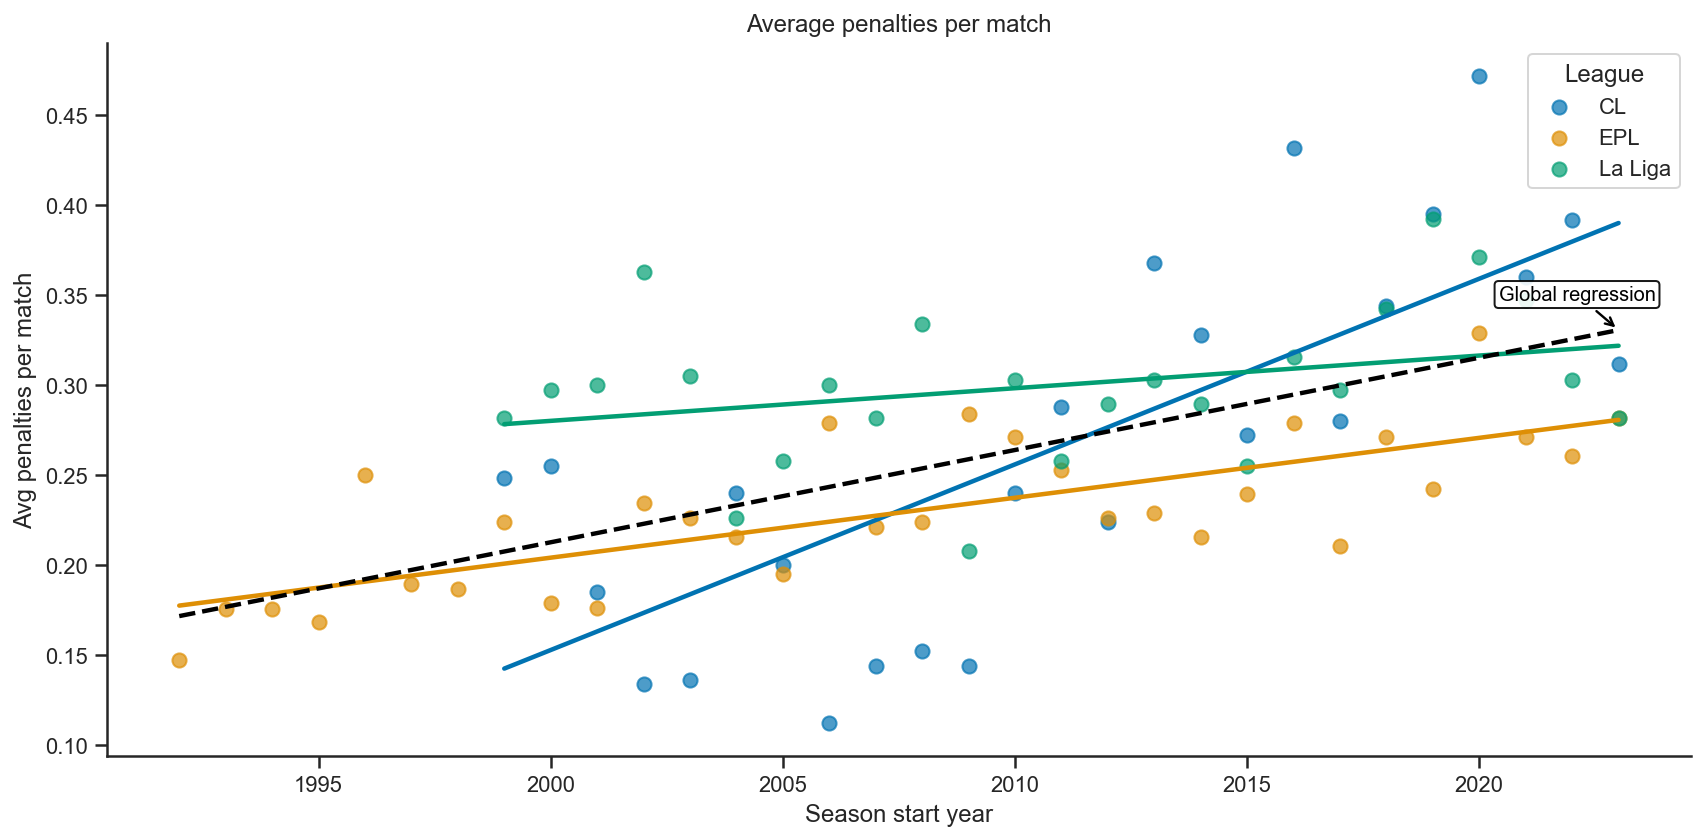

In [4]:
#| label: fig-penalties-per-match
#| fig-cap: Average penalties per match over time, by league (with global trend)
#| echo: false
#| include: true
# ---- Prep long_df ----
# --- Build AvgPerMatch per Season × Comp from df_with_dim (has matches_played) ---
avg = (df_with_dim.groupby(["Season","Comp"], as_index=False)
                 .agg(PKatt=("PKatt","sum"), matches=("matches_played","max")))
avg = avg[avg["matches"].gt(0)]
avg["AvgPerMatch"] = avg["PKatt"] / avg["matches"]

# --- Long tidy table expected by the plot code ---
long_df = avg.rename(columns={"Comp":"League"}).copy()
long_df["season_start"] = long_df["Season"].str.extract(r"^(\d{4})")[0].astype(int)
long_df = long_df.dropna(subset=["AvgPerMatch"])

# (Optional) sort for neatness
long_df = long_df.sort_values(["League","season_start"])

# --- Plot: per-league regressions + global regression ---
g = sns.lmplot(
    data=long_df,
    x="season_start", y="AvgPerMatch",
    hue="League",
    height=6, aspect=2,
    markers="o", ci=None,
    scatter_kws={"s": 50, "alpha": 0.7},
    legend=True, legend_out=False
)

ax = g.axes[0, 0]

# Global regression (black dashed)
valid = long_df.dropna(subset=["season_start","AvgPerMatch"])
sns.regplot(
    data=valid, x="season_start", y="AvgPerMatch",
    scatter=False, ci=None, color="black",
    line_kws={"linewidth": 2.2, "linestyle": "--"},
    ax=ax
)

# Label the global line (use offset so it doesn't clip)
x = valid["season_start"].to_numpy()
y = valid["AvgPerMatch"].to_numpy()
m, b = np.polyfit(x, y, 1)
x_ann = x.max(); y_ann = m * x_ann + b
ax.annotate(
    "Global regression",
    xy=(x_ann, y_ann),
    xytext=(-60, 15), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.2, color="black"),
    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="black", alpha=0.9),
    fontsize=10, color="black"
)

ax.set_title("Average penalties per match")
ax.set_xlabel("Season start year")
ax.set_ylabel("Avg penalties per match")
plt.tight_layout()
plt.show()

In [5]:
#| label: fig-penalties-per-match-plotly
#| echo: false
#| include: true

# ---- Build figure ----
fig = go.Figure()

plot_df = long_df.dropna(subset=["League", "season_start", "AvgPerMatch"]).copy()
plot_df = plot_df.sort_values(["League","season_start"])

# 1) Points per league
for lg, g in plot_df.groupby("League", sort=True):
    fig.add_trace(go.Scatter(
        x=g["season_start"], y=g["AvgPerMatch"],
        mode="markers",
        name=f"{lg}",
        legendgroup=lg,
        hovertemplate="Season start: %{x}<br>Avg/Match: %{y:.3f}<extra></extra>"
    ))
    # Trend line
    if len(g) >= 2:
        x = g["season_start"].to_numpy()
        y = g["AvgPerMatch"].to_numpy()
        m, b = np.polyfit(x, y, 1)
        x_fit = np.array([x.min(), x.max()])
        y_fit = m * x_fit + b
        fig.add_trace(go.Scatter(
            x=x_fit, y=y_fit,
            mode="lines",
            name=f"{lg} trend",
            legendgroup=lg,
            showlegend=False,
            hoverinfo="skip"
        ))

# 2) Global regression
x_all = plot_df["season_start"].to_numpy()
y_all = plot_df["AvgPerMatch"].to_numpy()
if len(x_all) >= 2:
    m_all, b_all = np.polyfit(x_all, y_all, 1)
    xg = np.array([x_all.min(), x_all.max()])
    yg = m_all * xg + b_all
    fig.add_trace(go.Scatter(
        x=xg, y=yg,
        mode="lines",
        name="Global regression",
        line=dict(dash="dash", width=3, color="black"),
        hoverinfo="skip"
    ))

# ---- Layout ----
fig.update_layout(
    title="Average penalties per match over time (interactive)",
    xaxis_title="Season start year",
    yaxis_title="Average penalties per match",
    legend_title="",
    hovermode="x unified",
    template="plotly_white",
    margin=dict(l=60, r=30, t=60, b=60)
)
fig.update_xaxes(dtick=2)

# ---- Export to Jekyll assets ----
site_root = r"C:\Users\eoind\Documents\Projects\jekyll_sites\diggydigsdata.github.io"
assets_subdir = "assets/plots"
os.makedirs(os.path.join(site_root, assets_subdir), exist_ok=True)

html_file = os.path.join(site_root, assets_subdir, "penalties_over_time.html")
fig.write_html(html_file, include_plotlyjs="cdn", full_html=True)

# ---- Emit iframe into the post ----
from IPython.display import display, HTML
iframe_html = f'<iframe src="{{{{ "/{assets_subdir}/penalties_over_time.html" | relative_url }}}}" width="100%" height="600" frameborder="0" loading="lazy"></iframe>'
display(HTML(iframe_html))

C:\Users\eoind\anaconda3\envs\stats-env\Lib\site-packages\IPython\core\display.py:447: UserWarning:

Consider using IPython.display.IFrame instead



# Methodology

## Penalty sampling
I have whipped up the following (courtesy of Stathead / FBref):

- Every normal time penalty taken in the Premier League - in other words, since the 1992/1993 season
- Every normal time penalty taken in the Champions League since the 1999/2000 season
- Every normal time penalty taken in La Liga since the 1999/2000 season

| **League**       | **Total Penalties** |
| ---------------- | ------------------- |
| Premier League   | 2892                |
| La Liga          | 2956                |
| Champions League | 925                 |
| **Total**        | **6773**            |

## Age bands
Finally, I have constructed some age groupings. See . This is in order to prevent small samples for different ages giving unreliable values. For example, there is a 20% difference in the success rate for La Liga 19 year-olds compared 20 year-olds. However, given these age groups have relatively few attempts it's easy for the data to get a little wild.

I think the groups I have created are fairly logical. At the top and bottom end we've got open intervals - we can have players from 0 to 20; though the youngest penalty taker in this data is 17. And our 33+ group can go to infinity. Though the oldest penalty taker is ..
This group are called No Fear At That Age? Because it's the age when expectations are minimal, you are at your most naive, innocent, etc. And the elder statesmen are called Cherry on Top. I would theorise that they also have a bit less pressure, because they have already had a good career, and nobody is looking at their performance as a measure of their potential. They are a known quantity by this point.

They sandwich 3-year age bands. 21-23 could be the most pressurised age. That's the point at which many wonderkid careers have gone awry - think Bojan Krkic. It's the moment when you need to step up, mature, realise your potential and be consistent. Otherwise, a journeyman career in the lower leagues could await you. Then 24-26 could constitute the beginning of a player's peak years. 27-29 would often be considered, depending a little on position, the absolute peak years of the average player. 30-32 has proven very fruitful for many players too. However, the perspective on these players definitely shifts. At this point, pressure amplifies because pundits and fans are often questioning whether you are 'past it', whether you should get a multi-year contract renewal or not. Just look at Mo Salah. In 2024/2025 he has having a career year but, at the age of 32, Liverpool have spent all season agonising about whether to give him a commensurate contract because of his age.

### Caveat

One enormous **caveat**, however, is that the ages provided by Stathead simply use the player's age at the commencement of the season, not their age at the time of taking a penalty. Consequently, the oldest penalty taker in the dataset is Teddy Sheringham. He appears as 39 in my dataset, but he had recently turned 40 when he missed a final-day penalty for West Ham against Tottenham in the 2005/06 season. Jorge Molina also appears as 39 in my dataset, but he was 40 when he missed against Espanyol on the final day of the 2021/22 season, effectively relegating Granada from La Liga.

Similarly, the dataset indicates a 17 year-old - Bojan Krkic. But he was 18 by the time he took his penalty for Barcelona against Manchester United in the Champions League. This is all rather annoying, but it would be more trouble than it's worth to separate out every single penalty from each player's season statistics and dial in the taker's age on a specific date. It just means there is a +/- of 9 months (i.e. the length of a season) for each player's age.

In [6]:
# Loop through float columns and convert to Int64 if they contain only whole numbers
for col in df.select_dtypes(include="float"):
    if (df[col].dropna() % 1 == 0).all():
        df[col] = df[col].astype("Int64")
df[df.select_dtypes(include="object").columns] = df.select_dtypes(include="object").astype("string")

bins = [-float("inf"), 20, 23, 26, 29, 32, float("inf")]
labels = [
    "<=20: No Fear At That Age?",
    "21-23: Not A Kid Anymore",
    "24-26: Early Peak",
    "27-29: Peak Peak",
    "30-32: Over The Hill?",
    "33+: Cherry On Top",
]

# Apply to Age column
df["age_group"] = pd.cut(
    df["Age"].astype("float"),
    bins=bins,
    labels=labels,
    right=True
)

# Keep order for plotting
df["age_group"] = df["age_group"].astype("category")
df["age_group"] = df["age_group"].cat.set_categories(labels, ordered=True)

# Check the result
print(df.dtypes)

Player             string[python]
Season             string[python]
Age                         Int64
Nation             string[python]
Team               string[python]
Comp               string[python]
Pos                string[python]
PKatt                       Int64
PK                          Int64
PKm                         Int64
Conversion%               float64
conversion_rate           float64
age_group                category
dtype: object


## Averages

In this analysis I calculate **conversion rates** in two different ways, which reflect slightly different questions:

- **Weighted (overall) mean**: This is the percentage of all penalties scored divided by the total penalties attempted within a group (e.g. a competition). Every penalty counts equally, so players who take more penalties have more influence. This measure tells us the *true success rate of the group as a whole*.

- **Unweighted (player) mean**: This is the simple average of individual players’ conversion rates. Each player counts equally, no matter how many penalties they have taken. This measure answers the question: *what does the “average player” in this group look like?*

In the charts shown here, the main benchmark (red dashed line) is the **weighted overall mean**, because it reflects the actual outcome of all penalties taken across the dataset.

In [7]:
#| code-summary: "Code for weighted conversion calculation"

# Weighted conversion by competition
grouped = (
    df.groupby('Comp', as_index=True)[['PKatt', 'PK', 'PKm']]
      .sum()
)

# Percent scored/missed (sums to 100)
grouped['Scored %'] = (grouped['PK']  / grouped['PKatt']) * 100
grouped['Missed %'] = (grouped['PKm'] / grouped['PKatt']) * 100

# Overall weighted mean (all penalties pooled)
overall_mean = (df['PK'].sum() / df['PKatt'].sum()) * 100

## Analysis

First off, when it comes to conversion rates across the leagues, there are no differences whatsoever. Which is boring but convenient that we don't need to worry too much about league effects.

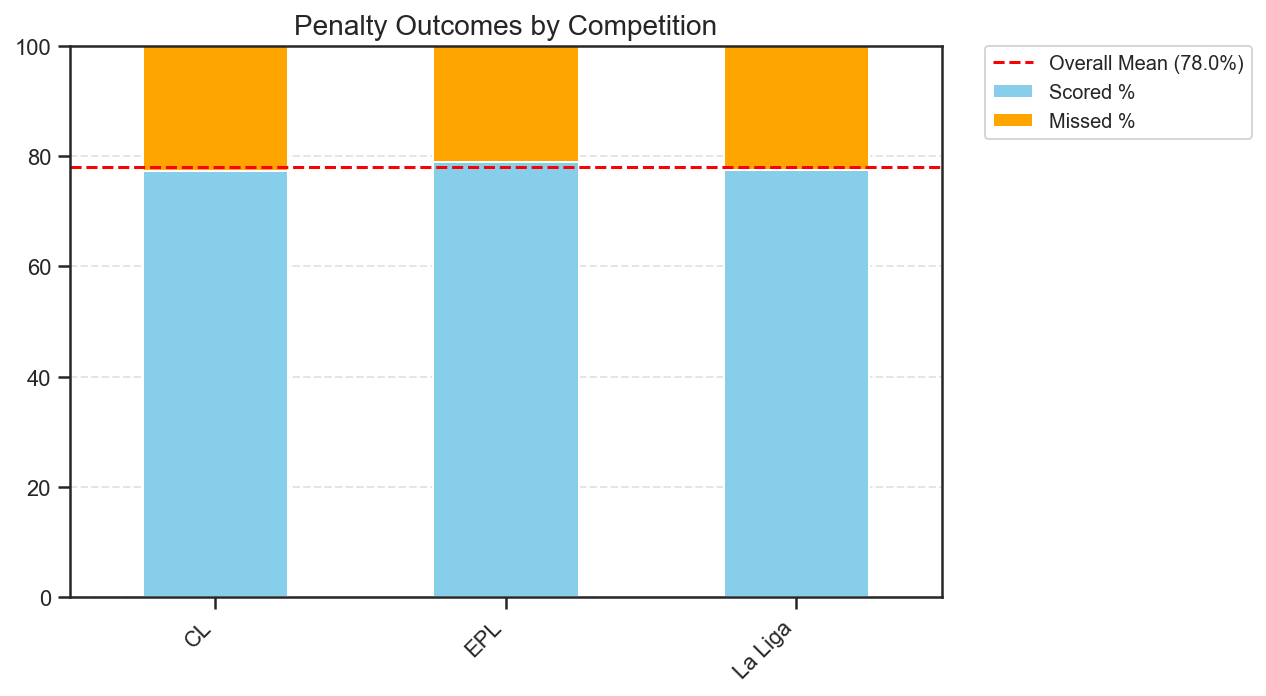

         PKatt    PK  PKm  conversion_rate
Comp                                      
CL         925   714  211        77.189189
EPL       2892  2280  612        78.838174
La Liga   2956  2288  668        77.401894


In [8]:
#| echo: false
#| include: true

# 100% stacked bar
ax = grouped[['Scored %', 'Missed %']].plot(
    kind='bar',
    stacked=True,
    figsize=(9, 5),
    color=['skyblue', 'orange'],
    ax=None
)

# Add overall mean line
ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5,
           label=f'Overall Mean ({overall_mean:.1f}%)')

# Labels and style
ax.set_title('Penalty Outcomes by Competition', fontsize=14)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_ylim(0, 100)
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45, ha='right')

# Move legend outside to the right
ax.legend(
    title='',
    fontsize=10,
    bbox_to_anchor=(1.05, 1),  # 1.05 = just outside right
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()

# Group by 'Comp' and calculate sums
grouped = df.groupby('Comp')[['PKatt', 'PK', 'PKm']].sum()
grouped['conversion_rate'] = (grouped['PK'] / grouped['PKatt']) * 100
print(grouped)

Or do we? Any differences when we break the leagues down by age group?

There's *maybe* a trend towards improved penalty conversion as you accumulate experience. The 'no fear' players are *slightly* more clinical than the players aged 21-23 who may be coming under pressure to make the next step as more mature and consistent players.

But this is the smallest dataset - only 925 penalties.

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3970729002.py:6: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3970729002.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3970729002.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3970729002.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



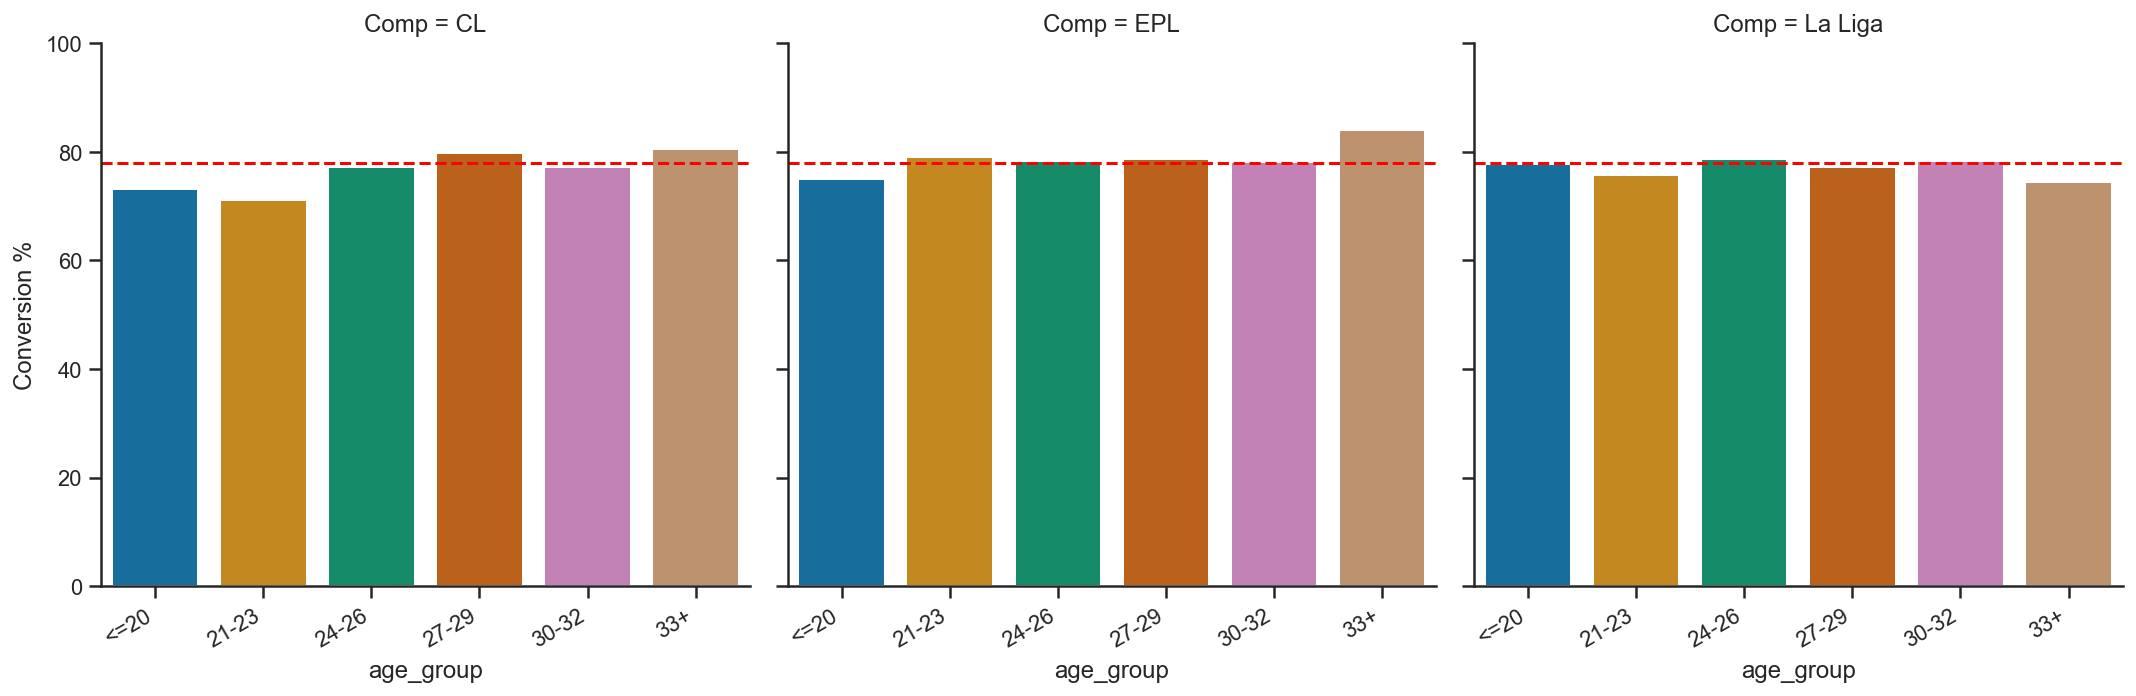

In [9]:
#| echo: false
#| include: true
# Global
# By League

# Aggregate: sum penalties by age group × league
agg = (
    df.groupby(["age_group", "Comp"], as_index=False)[["PK", "PKatt"]].sum()
)

# Weighted conversion rate (%)
agg["weighted_conv%"] = (agg["PK"] / agg["PKatt"]) * 100

g = sns.catplot(
    data=agg,
    x="age_group",
    y="weighted_conv%",
    col="Comp",
    hue="age_group",
    kind="bar"
)
g.set(ylim=(0, 100))

# Set nicer x-tick labels
new_labels = ["<=20", "21-23", "24-26", "27-29", "30-32", "33+"]
for ax in g.axes.flatten():
    ax.set_xticklabels(new_labels, rotation=30, ha="right")

    # Add an overall mean line to each subplot
    ax.axhline(overall_mean, color="red", linestyle="--", linewidth=1.5)

    ax.set_ylabel("Conversion %")
plt.tight_layout()
plt.show()

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3836925691.py:12: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



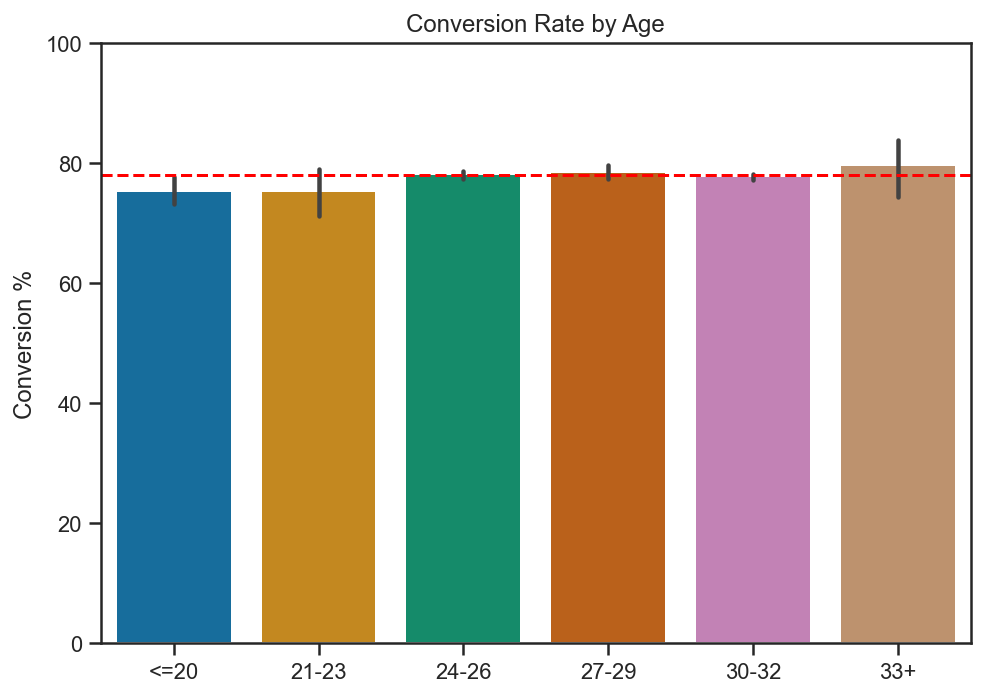

In [10]:
#| echo: false
#| include: true
fig, ax = plt.subplots()
sns.barplot(
    data=agg,
    x="age_group",
    y="weighted_conv%",
    hue='age_group',
    ax=ax)
ax.set_title('Conversion Rate by Age')
ax.set_xlabel("")
ax.set_ylabel("Conversion %")
ax.set_ylim(0, 100)
ax.set_xticklabels(["<=20", '21-23', '24-26', '27-29', '30-32', '33+'])
ax.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5,
           label=f'Overall Mean ({overall_mean:.1f}%)')
plt.tight_layout()
plt.show()

### Age Group Penalty Data (Premier League)

| Age Group                  | Penalty Attempts | Penalty Conversions | Conversion Rate (%) |
| -------------------------- | ---------------- | ------------------- | ------------------- |
| <=20: No Fear At That Age? | 80               | 60                  | 75.00               |
| 21-23: Not A Kid Anymore   | 503              | 398                 | 79.13               |
| 24-26: Early Peak          | 834              | 654                 | 78.42               |
| 27-29: Peak Peak           | 793              | 624                 | 78.69               |
| 30-32: Over The Hill?      | 495              | 387                 | 78.18               |
| 33+: Cherry On Top         | 187              | 157                 | 83.96               |
| **Grand Total**            | **2892**         | **2280**            | **78.84**           |

In the Premier League, things level out a bit more, although there still seems to be a mild advantage for experience.

### Age Group Penalty Data (La Liga)

| Age Group                  | Penalty Attempts | Penalty Conversions | Conversion Rate (%) |
| -------------------------- | ---------------- | ------------------- | ------------------- |
| <=20: No Fear At That Age? | 81               | 63                  | 77.78               |
| 21-23: Not A Kid Anymore   | 405              | 307                 | 75.80               |
| 24-26: Early Peak          | 829              | 653                 | 78.77               |
| 27-29: Peak Peak           | 833              | 644                 | 77.31               |
| 30-32: Over The Hill?      | 511              | 400                 | 78.28               |
| 33+: Cherry On Top         | 297              | 221                 | 74.41               |
| **Grand Total**            | **2956**         | **2288**            | **77.40**           |

Things get flipped on their head a little bit in La Liga. For the first time, the Cherry on Top vets aren't the most effective penalty takers. In fact, in La Liga they are the worst. Meanwhile, the 20s and under are right up there near the top. And if we drill down into that age group, we can really appreciate how precocious those La Liga teens are.

| Age Group                  | Penalty Attempts | Penalty Conversions | Conversion Rate (%) |
| -------------------------- | ---------------- | ------------------- | ------------------- |
| <=20: No Fear At That Age? | 81               | 63                  | 77.78               |
| 18                         | 10               | 8                   | 80.00               |
| 19                         | 27               | 24                  | 88.89               |
| 20                         | 44               | 31                  | 70.45               |

Let's remove the 20 year olds. Now, La Liga teens have a success rate of 86%! Of course, there's a caveat... That's a population size of just 37. Ezequiel Garay - one of history's great centre-back penalty takers and a stalwart of my FC Atlas team in Football Manager - accounts for 22% of the entire La Liga teenage penalty taking population. And Jose Antonio Reyes accounts for another 19%. All together, those two players - and their combined 92% success rate - represent 41% of the whole group.

So let's bundle everything together and see what we get...

| Age Group                 | Penalty Attempts | Penalty Conversions | Conversion Rate (%) |
| ------------------------- | ---------------- | ------------------- | ------------------- |
| <=20: No Fear At That Age | 202              | 153                 | 75.74               |
| 21-23: Not A Kid Anymore  | 1047             | 804                 | 76.79               |
| 24-26: Early Peak         | 1901             | 1491                | 78.43               |
| 27-29: Peak Peak          | 1898             | 1485                | 78.24               |
| 30-32: Over The Hill?     | 1164             | 909                 | 78.09               |
| 33+: Cherry On Top        | 561              | 440                 | 78.43               |
| **Grand Total**           | **6773**         | **5282**            | **77.99**           |

There is a *very* mild indication that more experienced players do better than younger players. Considering the lowest success rates are 20 and under, and 21-23 are 2nd-lowest, there is some indication that young players are not totally fearless. I think this could be particularly noteworthy because, players who are designated penalty takers at such a young are rare and they are, in all likelihood, technically gifted. Therefore, is it a psychological vulnerability that causes their penalty-taking to dip a little compared to their older peers? And that maybe they aren't so impervious to fear as pundits may casually claim?

Let's see if this stands up to statistical scrutiny.

Data assembled from: [Stathead](https://stathead.com/fbref/)

### Logistic Regression
#### Method

Each penalty in the dataset is tied to a player, season, and league. Since some players take penalties in multiple seasons (or even in multiple leagues), the raw data contained repeated rows for the same player. To avoid overweighting those players, we collapsed the dataset to one row per **player × age group × league**, summing up penalties scored and attempted within each cell. This way, every player contributes fairly to the analysis.

I used a **logistic regression model** because the outcome of interest—scoring or missing a penalty—is binary. Logistic regression lets us model the probability of success while accounting for the number of attempts in each cell. We tested age group, league, and their interaction to see if any of them had an effect on conversion rates. Confidence intervals were estimated around the predicted probabilities to judge how much overlap there was between groups.

#### Results

To test whether penalty conversion varies by age or by league, I fit a logistic regression with both predictors and their interaction. The likelihood-ratio tests showed no evidence that either factor—or their combination—improves model fit (all p > .4). In other words, neither age group nor league explains variation in conversion odds.

Predicted probabilities were remarkably consistent across groups, generally hovering between **73% and 84%**. For instance:

- **≤20 years**: 73–78% across leagues  
- **21–23 years**: 71–79%  
- **27–29 years (peak)**: 77–79%  
- **33+ years**: 74–84%  

Confidence intervals overlapped substantially, indicating no systematic age or league effect.

*Note: Bars show predicted conversion probabilities with 95% confidence intervals. The dashed line indicates the overall average (~78%).*

In [11]:
#| label: fig-age-vs-success
#| fig-cap: conversion by age
#| echo: false
#| include: false

# --- 0) Assumes df has: Player, Age, age_group (categorical), Comp (string),
#                         PK (scored), PKatt (attempts)

# --- 1) Clean rows we can’t model ---
dfm = df.copy()
req = ["Player", "age_group", "Comp", "PK", "PKatt"]
dfm = dfm.dropna(subset=req)
dfm = dfm[dfm["PKatt"] > 0]
dfm = dfm[(dfm["PK"] >= 0) & (dfm["PK"] <= dfm["PKatt"])]

# Ensure categorical dtypes (helps with reference levels & ordering)
dfm["age_group"] = dfm["age_group"].astype("category")
dfm["Comp"] = dfm["Comp"].astype("category")

# --- 2) Collapse to one row per Player × age_group × Comp ---
collapsed = (
    dfm.groupby(["Player", "age_group", "Comp"], as_index=False)[["PK", "PKatt"]]
       .sum()
)

# Drop cells with zero attempts (safety)
collapsed = collapsed[collapsed["PKatt"] > 0]

# Proportion (response) and weights (trials)
collapsed["prop"] = collapsed["PK"] / collapsed["PKatt"]

# Optional: peek at sparsity by cell
cell_counts = (
    collapsed.groupby(["age_group", "Comp"], as_index=False)["PKatt"].sum()
    .rename(columns={"PKatt": "total_attempts"})
).sort_values(["age_group", "Comp"])
print("\nCell totals (attempts) by age_group × Comp:\n", cell_counts)

# --- 3) Fit models: null, additive, interaction ---
null_mod = smf.glm(
    "prop ~ 1",
    data=collapsed,
    family=sm.families.Binomial(),
    var_weights=collapsed["PKatt"]
).fit()

add_mod = smf.glm(
    "prop ~ C(age_group) + C(Comp)",
    data=collapsed,
    family=sm.families.Binomial(),
    var_weights=collapsed["PKatt"]
).fit()

int_mod = smf.glm(
    "prop ~ C(age_group) * C(Comp)",
    data=collapsed,
    family=sm.families.Binomial(),
    var_weights=collapsed["PKatt"]
).fit()

print("\n=== Additive model summary ===")
print(add_mod.summary())
print("\n=== Interaction model summary ===")
print(int_mod.summary())

# --- 4) Likelihood-ratio (LR) tests ---
def lr_test(mod_big, mod_small, name):
    LR = 2 * (mod_big.llf - mod_small.llf)
    df_diff = int(mod_big.df_model - mod_small.df_model)
    pval = chi2.sf(LR, df_diff)
    print(f"{name}: LR χ²({df_diff}) = {LR:.3f}, p = {pval:.4g}")

print("\n=== LR tests ===")
lr_test(add_mod, null_mod, "Additive vs Null")
lr_test(int_mod, add_mod, "Interaction vs Additive")

# --- 5) Predicted probabilities per age_group × Comp (with 95% CI) ---
pred_grid = (
    collapsed[["age_group", "Comp"]]
    .drop_duplicates()
    .sort_values(["age_group", "Comp"])
)

pred_res = int_mod.get_prediction(pred_grid)
pred_ci = pred_res.conf_int()
pred_df = pred_grid.copy()
pred_df["pred_prob"] = pred_res.predicted_mean
pred_df["ci_low"] = pred_ci[:, 0]
pred_df["ci_high"] = pred_ci[:, 1]

print("\nPredicted conversion probability by age group × Comp (95% CI):")
print(pred_df)

# --- 6) (Optional) Cluster-robust SEs by Player for the interaction model ---
int_mod_cluster = smf.glm(
    "prop ~ C(age_group) * C(Comp)",
    data=collapsed,
    family=sm.families.Binomial(),
    var_weights=collapsed["PKatt"]
).fit(cov_type="cluster", cov_kwds={"groups": collapsed["Player"]})

print("\n=== Interaction model (cluster-robust SEs by Player) ===")
print(int_mod_cluster.summary())


Cell totals (attempts) by age_group × Comp:
                      age_group     Comp  total_attempts
0   <=20: No Fear At That Age?       CL              41
1   <=20: No Fear At That Age?      EPL              80
2   <=20: No Fear At That Age?  La Liga              81
3     21-23: Not A Kid Anymore       CL             139
4     21-23: Not A Kid Anymore      EPL             503
5     21-23: Not A Kid Anymore  La Liga             405
6            24-26: Early Peak       CL             238
7            24-26: Early Peak      EPL             834
8            24-26: Early Peak  La Liga             829
9             27-29: Peak Peak       CL             272
10            27-29: Peak Peak      EPL             793
11            27-29: Peak Peak  La Liga             833
12       30-32: Over The Hill?       CL             158
13       30-32: Over The Hill?      EPL             495
14       30-32: Over The Hill?  La Liga             511
15          33+: Cherry On Top       CL              77
16

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3128275158.py:17: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\eoind\AppData\Local\Temp\ipykernel_63736\3128275158.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

C:\Users\eoind\anaconda3\envs\stats-env\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1655: SpecificationWarning:

cov_type not fully supported with var_weights



In [12]:
#| label: logistic-regression
#| tbl-cap: conversion by age
#| echo: false
#| include: true
# print("\nPredicted conversion probability by age group × Comp (95% CI):")
pred_df

,age_group,Comp,pred_prob,ci_low,ci_high
720,<=20: No Fear At That Age?,CL,0.731707,0.577484,0.844769
721,<=20: No Fear At That Age?,EPL,0.750000,0.643950,0.832670
452,<=20: No Fear At That Age?,La Liga,0.777778,0.674573,0.855275
309,21-23: Not A Kid Anymore,CL,0.712230,0.631588,0.781332
94,21-23: Not A Kid Anymore,EPL,0.791252,0.753518,0.824555
41,21-23: Not A Kid Anymore,La Liga,0.758025,0.713916,0.797264
258,24-26: Early Peak,CL,0.773109,0.715574,0.821903
7,24-26: Early Peak,EPL,0.784173,0.754948,0.810785
26,24-26: Early Peak,La Liga,0.787696,0.758529,0.814203
333,27-29: Peak Peak,CL,0.797794,0.745865,0.841369
